# Import supporting package

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import copy

import glob

import xrft
import finufft

from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

from datetime import datetime

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18

from DataContainer.ReadData import read_hdf5_file, read_hdf5_global, read_hdf5_run_time, read_csv_file
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from Analyser.FitAnalyser import ThomasFermi2dModel, DensityProfileBEC2dModel, Polylog22dModel
from Analyser.FFTAnalyser import fft, ifft, fft_nutou
from ToolFunction.ToolFunction import *

from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

imageAnalyser = ImageAnalyser()

## Start a client for parallel computing

In [2]:
from dask.distributed import Client
client = Client(n_workers=6, threads_per_worker=4, processes=True, memory_limit='8GB')
client

<Client: 'tcp://127.0.0.1:61384' processes=6 threads=24, memory=44.70 GiB>

## Set global path for experiment

In [3]:
groupList = [
    "images/MOT_3D_Camera/in_situ_absorption",
    "images/ODT_1_Axis_Camera/in_situ_absorption",
    "images/ODT_2_Axis_Camera/in_situ_absorption",
]

dskey = {
    "images/MOT_3D_Camera/in_situ_absorption": "camera_0",
    "images/ODT_1_Axis_Camera/in_situ_absorption": "camera_1",
    "images/ODT_2_Axis_Camera/in_situ_absorption": "camera_2",
}


In [4]:
img_dir = '//DyLabNAS/Data/'
SequenceName = "Evaporative_Cooling" + "/"
folderPath = img_dir + SequenceName + '2023/05/12'# get_date()

In [5]:
shotNum = "0065"
filePath = folderPath + "/" + shotNum + "/*.h5"

# load the data from HDF5 files
dataSetDict = {
    dskey[groupList[i]]: read_hdf5_file(filePath, groupList[i])
    for i in [0] # range(len(groupList))
}

# selecte the data for centain camera
dataSet = dataSetDict["camera_0"]
# flip the x and y axis
dataSet = swap_xy(dataSet)

# get the scan axis name of the shot
scanAxis = get_scanAxis(dataSet)

# rechunck the data for parallel computing
dataSet = auto_rechunk(dataSet)

# calculate the absorption imaging
dataSet = imageAnalyser.get_absorption_images(dataSet)

dataSet

OD = dataSet["OD"]

OD_np = OD.to_numpy()

dataSet

<xarray.Dataset>
Dimensions:       (sin_mod_freq: 37, y: 1200, x: 1920)
Coordinates:
  * sin_mod_freq  (sin_mod_freq) float64 65.0 66.0 67.0 ... 99.0 100.0 101.0
Dimensions without coordinates: y, x
Data variables:
    atoms         (sin_mod_freq, y, x) uint16 dask.array<chunksize=(29, 1200, 1920), meta=np.ndarray>
    background    (sin_mod_freq, y, x) uint16 dask.array<chunksize=(29, 1200, 1920), meta=np.ndarray>
    dark          (sin_mod_freq, y, x) uint16 dask.array<chunksize=(29, 1200, 1920), meta=np.ndarray>
    shotNum       (sin_mod_freq) <U2 dask.array<chunksize=(37,), meta=np.ndarray>
    OD            (sin_mod_freq, y, x) float64 dask.array<chunksize=(29, 1200, 1920), meta=np.ndarray>
Attributes: (12/109)
    TOF_free:                          0.01
    abs_img_freq:                      110.858
    absorption_imaging_flag:           True
    backup_data:                       True
    blink_off_time:                    0.001
    blink_on_time:                     0.001
    ...                                ...
    y_offset_img:                      0
    z_offset:                          0.189
    z_offset_img:                      0.189
    sin_mod_freq:                      [ 65.  66.  67.  68.  69.  70.  71.  7...
    scanAxis:                          ['sin_mod_freq']
    scanAxisLength:                    [37.]

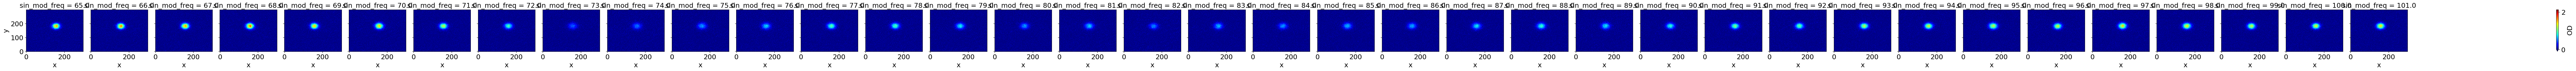

In [17]:
imageAnalyser.center = (950, 250)
imageAnalyser.span = (300, 300)
imageAnalyser.fraction = (0.1, 0.1)

dataSet_cropOD = imageAnalyser.crop_image(dataSet.OD)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()

dataSet_cropOD.plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[0], row=scanAxis[1])
plt.show()

In [18]:
dataSet_cropOD

<xarray.DataArray 'OD' (sin_mod_freq: 37, y: 300, x: 300)>
array([[[ 0.0020338 ,  0.11597806,  0.01753798, ...,  0.03280546,
          0.0020338 , -0.03570653],
        [-0.08497758,  0.02072593, -0.12425993, ...,  0.0020338 ,
          0.21334289, -0.05405567],
        [-0.0865196 ,  0.11123309,  0.06265842, ...,  0.21774237,
          0.0903264 , -0.08373303],
        ...,
        [ 0.0020338 ,  0.01803414, -0.15960755, ..., -0.04448622,
         -0.012565  , -0.03935142],
        [ 0.02038294,  0.18072559,  0.05246465, ...,  0.16367515,
          0.0020338 ,  0.05838673],
        [-0.07207418,  0.03712512, -0.04756314, ...,  0.01730127,
          0.0020338 , -0.06465758]],

       [[-0.16688474, -0.04827899, -0.03207702, ...,  0.16731735,
         -0.03088725,  0.03810562],
        [-0.0855391 , -0.12560308, -0.03335334, ..., -0.04577586,
          0.06861158,  0.05261124],
        [-0.0871368 ,  0.10017805,  0.0030143 , ...,  0.06755282,
          0.12079734,  0.0749878 ],
...
        [-0.12844621,  0.19080233, -0.02825124, ...,  0.06307244,
          0.03539053, -0.00930355],
        [ 0.02488781,  0.06014496,  0.10686788, ...,  0.00508518,
          0.07919316,  0.00508518],
        [ 0.02217962,  0.09861124,  0.02247693, ...,  0.01990027,
          0.05020562, -0.0421677 ]],

       [[-0.06362606,  0.08931324, -0.03830825, ..., -0.08509483,
          0.02421211,  0.01016299],
        [ 0.01016299, -0.1559566 , -0.02523617, ...,  0.08483673,
         -0.00753659,  0.00927053],
        [-0.00753659,  0.15609283,  0.01266612, ..., -0.00753659,
          0.0079676 , -0.02280406],
        ...,
        [-0.04527692, -0.06064642,  0.06266767, ..., -0.07652946,
         -0.03784194,  0.00553549],
        [-0.08164456,  0.01048191, -0.02492833, ...,  0.02063429,
         -0.05478948, -0.07848833],
        [-0.00753659, -0.09608999,  0.08261451, ...,  0.02276876,
          0.1259948 , -0.08056173]]])
Coordinates:
  * sin_mod_freq  (sin_mod_freq) float64 65.0 66.0 67.0 ... 99.0 100.0 101.0
Dimensions without coordinates: y, x
Attributes:
    IMAGE_SUBCLASS:       IMAGE_GRAYSCALE
    IMAGE_VERSION:        1.2
    IMAGE_WHITE_IS_ZERO:  0
    x_start:              800
    x_end:                1100
    y_end:                400
    y_start:              100
    x_center:             950
    y_center:             250
    x_span:               300
    y_span:               300

In [19]:
dataSet_cropOD.to_numpy()

array([[[ 0.0020338 ,  0.11597806,  0.01753798, ...,  0.03280546,
          0.0020338 , -0.03570653],
        [-0.08497758,  0.02072593, -0.12425993, ...,  0.0020338 ,
          0.21334289, -0.05405567],
        [-0.0865196 ,  0.11123309,  0.06265842, ...,  0.21774237,
          0.0903264 , -0.08373303],
        ...,
        [ 0.0020338 ,  0.01803414, -0.15960755, ..., -0.04448622,
         -0.012565  , -0.03935142],
        [ 0.02038294,  0.18072559,  0.05246465, ...,  0.16367515,
          0.0020338 ,  0.05838673],
        [-0.07207418,  0.03712512, -0.04756314, ...,  0.01730127,
          0.0020338 , -0.06465758]],

       [[-0.16688474, -0.04827899, -0.03207702, ...,  0.16731735,
         -0.03088725,  0.03810562],
        [-0.0855391 , -0.12560308, -0.03335334, ..., -0.04577586,
          0.06861158,  0.05261124],
        [-0.0871368 ,  0.10017805,  0.0030143 , ...,  0.06755282,
          0.12079734,  0.0749878 ],
        ...,
        [-0.03402697, -0.03270378, -0.03207702, ...,  

In [ ]:
from Analyser.FitAnalyser import ThomasFermi2dModel, DensityProfileBEC2dModel, polylog2_2d

fitModel = DensityProfileBEC2dModel()
# fitModel = ThomasFermi2dModel()

fitAnalyser = FitAnalyser(fitModel, fitDim=2)

# fitAnalyser = FitAnalyser("Gaussian-2D", fitDim=2)

# dataSet_cropOD = dataSet_cropOD.chunk((1,1,100,100))

params = fitAnalyser.guess(dataSet_cropOD, guess_kwargs=dict(pureBECThreshold=0.3), dask="parallelized")
fitResult = fitAnalyser.fit(dataSet_cropOD, params).load()